# German Car License Plate Recognition

Datenset für das Training der OCR-Erkennung

### Importing Packages

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from scipy import misc
from skimage import data
import glob
import shutil

print ("TensorFlow Version: {}".format(tf.__version__))

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

TensorFlow Version: 2.1.0-rc1
GPU device: /device:GPU:0


### Training Parameter

In [2]:
from config import config

# datasets
TRAIN_HDF5 = config.TRAIN_HDF5
TEST_HDF5 = config.TEST_HDF5
SUN397_HDF5 = config.SUN397_HDF5

# input size
IMAGE_WIDTH = config.IMAGE_WIDTH
IMAGE_HEIGHT = config.IMAGE_HEIGHT

# train parameter
POOL_SIZE = config.POOL_SIZE
MAX_TEXT_LEN = config.MAX_TEXT_LEN

BATCH_SIZE = config.BATCH_SIZE
NUM_EPOCHS = config.NUM_EPOCHS

# supported optimizer methods: sdg, rmsprop, adam, adagrad, adadelta
OPTIMIZER = config.OPTIMIZER

OUTPUT_PATH = config.OUTPUT_PATH
DOCUMENTATION_PATH = config.DOCUMENTATION_PATH
MODEL_NAME = config.MODEL_NAME

MODEL_WEIGHTS_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + '-weights.h5'
MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + ".h5"
TEST_IMAGES = config.TEST_IMAGES

print("Train Dataset:      {}".format(TRAIN_HDF5))
print("Test Dataset:       {}".format(TEST_HDF5))
print("Background Dataset: {}".format(SUN397_HDF5))
print("Batch Size:         {}".format(BATCH_SIZE))
print("Epochs:             {}".format(NUM_EPOCHS))
print("Image Size:         ({}, {})".format(IMAGE_WIDTH, IMAGE_HEIGHT))
print("Optimizer:          {}".format(OPTIMIZER))
print("Model Name:         {}".format(MODEL_NAME))
print("Output Path:        {}".format(OUTPUT_PATH))
print("Documentation Path: {}".format(DOCUMENTATION_PATH))
print("Model Weights Path: {}".format(MODEL_WEIGHTS_PATH))
print("Model Path:         {}".format(MODEL_PATH))

Train Dataset:      D:\development\tensorflow\ANPR\..\datasets\clpr\hdf5/train.h5
Test Dataset:       D:\development\tensorflow\ANPR\..\datasets\clpr\hdf5/test.h5
Background Dataset: D:\development\tensorflow\ANPR\..\datasets\clpr\hdf5/background.h5
Batch Size:         100
Epochs:             1000
Image Size:         (128, 64)
Optimizer:          adadelta
Model Name:         clpr-model
Output Path:        output
Documentation Path: documentation
Model Weights Path: output\adadelta\clpr-model-weights.h5
Model Path:         output\adadelta\clpr-model.h5


### Data Loading

In [4]:
from pyimagesearch.io import Hdf5DatasetLoader
from sklearn.model_selection import train_test_split

loader = Hdf5DatasetLoader()
X_train, y_train = loader.load(TRAIN_HDF5, shuffle=True)
X_test, y_test = loader.load(TEST_HDF5, shuffle=True)

print("Train dataset size: {}".format(X_train.shape[0]))
print("Test dataset size:  {}".format(X_test.shape[0]))

#images, labels = loader.load(TRAIN_HDF5, shuffle=True)
#X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

Train dataset size: 65276
Test dataset size:  16319


C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


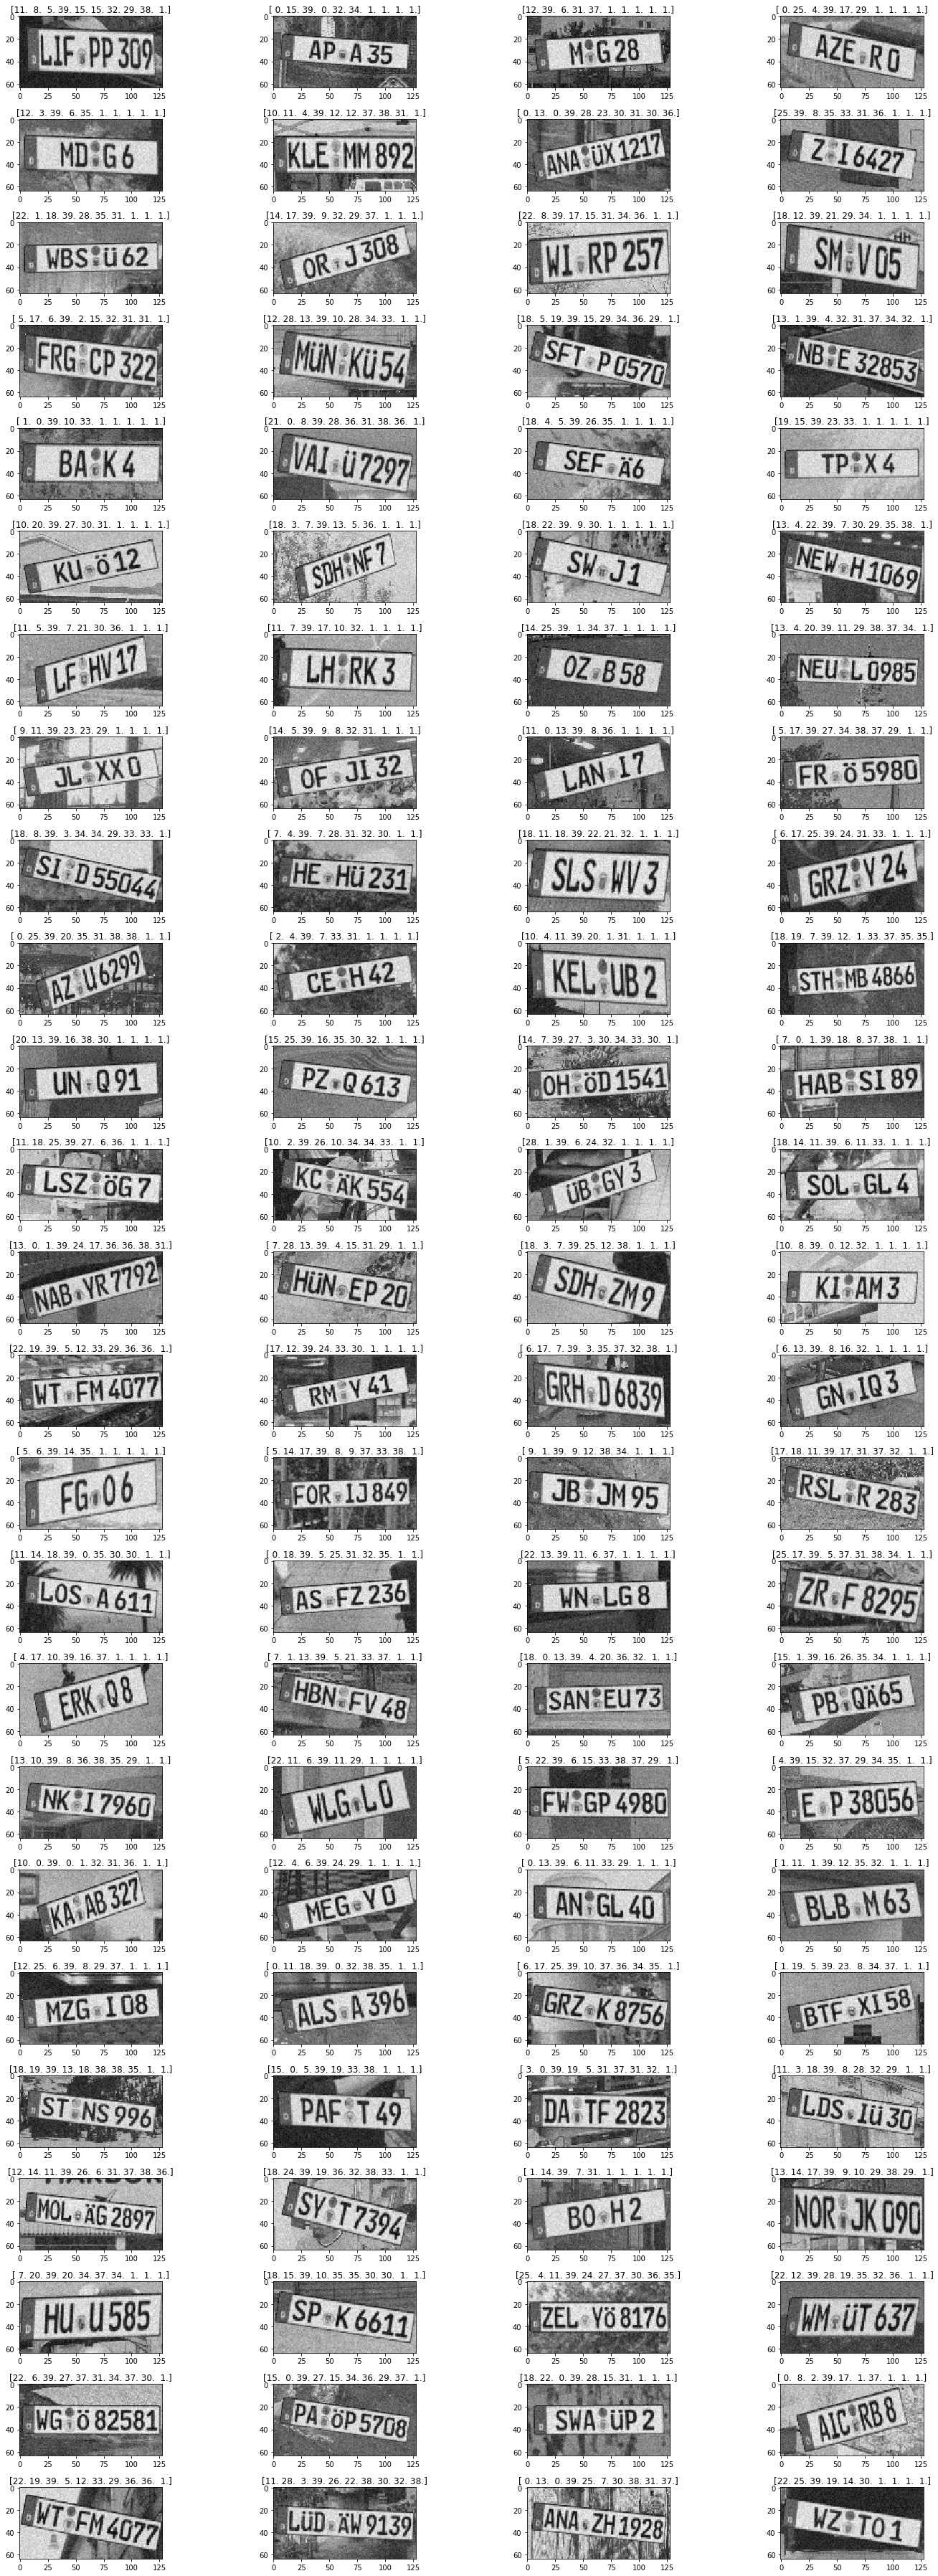

In [5]:
from pyimagesearch.io import Hdf5DatasetLoader
from license_plate_image_augmentator import LicensePlateImageAugmentator
from licence_plate_dataset_generator import LicensePlateDatasetGenerator
from label_codec import LabelCodec
import skimage

loader = Hdf5DatasetLoader()
background_images = loader.load(SUN397_HDF5, shuffle=True, max_items=10000)
    
augmentator = LicensePlateImageAugmentator(IMAGE_WIDTH, IMAGE_HEIGHT, background_images)
train_generator = LicensePlateDatasetGenerator(X_train, y_train, IMAGE_WIDTH, IMAGE_HEIGHT,
                                               POOL_SIZE, MAX_TEXT_LEN, BATCH_SIZE, augmentator)

val_generator = LicensePlateDatasetGenerator(X_test, y_test, IMAGE_WIDTH, IMAGE_HEIGHT,
                                             POOL_SIZE, MAX_TEXT_LEN, BATCH_SIZE, augmentator)

inputs = next(train_generator.generator())

def plotImages(images_arr, labels, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(20,50))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        img = img.T.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        ax.set_title(label)
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()
        
plotImages(inputs["input"], inputs["labels"], int(BATCH_SIZE / 4), 4)

### Create and train the OCR-Network

In [6]:
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from pyimagesearch.nn.conv import OCR
from label_codec import LabelCodec

def get_optimizer(optimizer):
    if optimizer == "sdg":
        return SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    if optimizer == "rmsprop":
        return RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    if optimizer == "adam":
        return Adam(lr=0.001, decay=0.001 / config.NUM_EPOCHS)
        # Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    if optimizer == "adagrad":
        return Adagrad(lr=0.01, epsilon=1e-08, decay=0.0)
    if optimizer == "adadelta":
        return Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
    
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, input_length, label_length, name='CTCLoss'):
        super().__init__(name=name)
        self.input_length = input_length
        self.label_length = label_length

    def call(self, labels, predictions):
        loss = tf.keras.backend.ctc_batch_cost(labels, predictions, self.input_length, self.label_length)
        loss = tf.reduce_mean(loss)
        return loss

tf.compat.v1.disable_eager_execution()

labels = Input(name='labels', shape=(MAX_TEXT_LEN,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')

inputs, predictions = OCR.build((IMAGE_WIDTH, IMAGE_HEIGHT, 1), POOL_SIZE, len(LabelCodec.ALPHABET) + 1)

train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=predictions)
train_model.add_loss(CTCLoss(input_length, label_length)(labels, predictions))
train_model.compile(loss=None, optimizer=get_optimizer(OPTIMIZER))

train_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 64, 16)  160         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 64, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 64, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

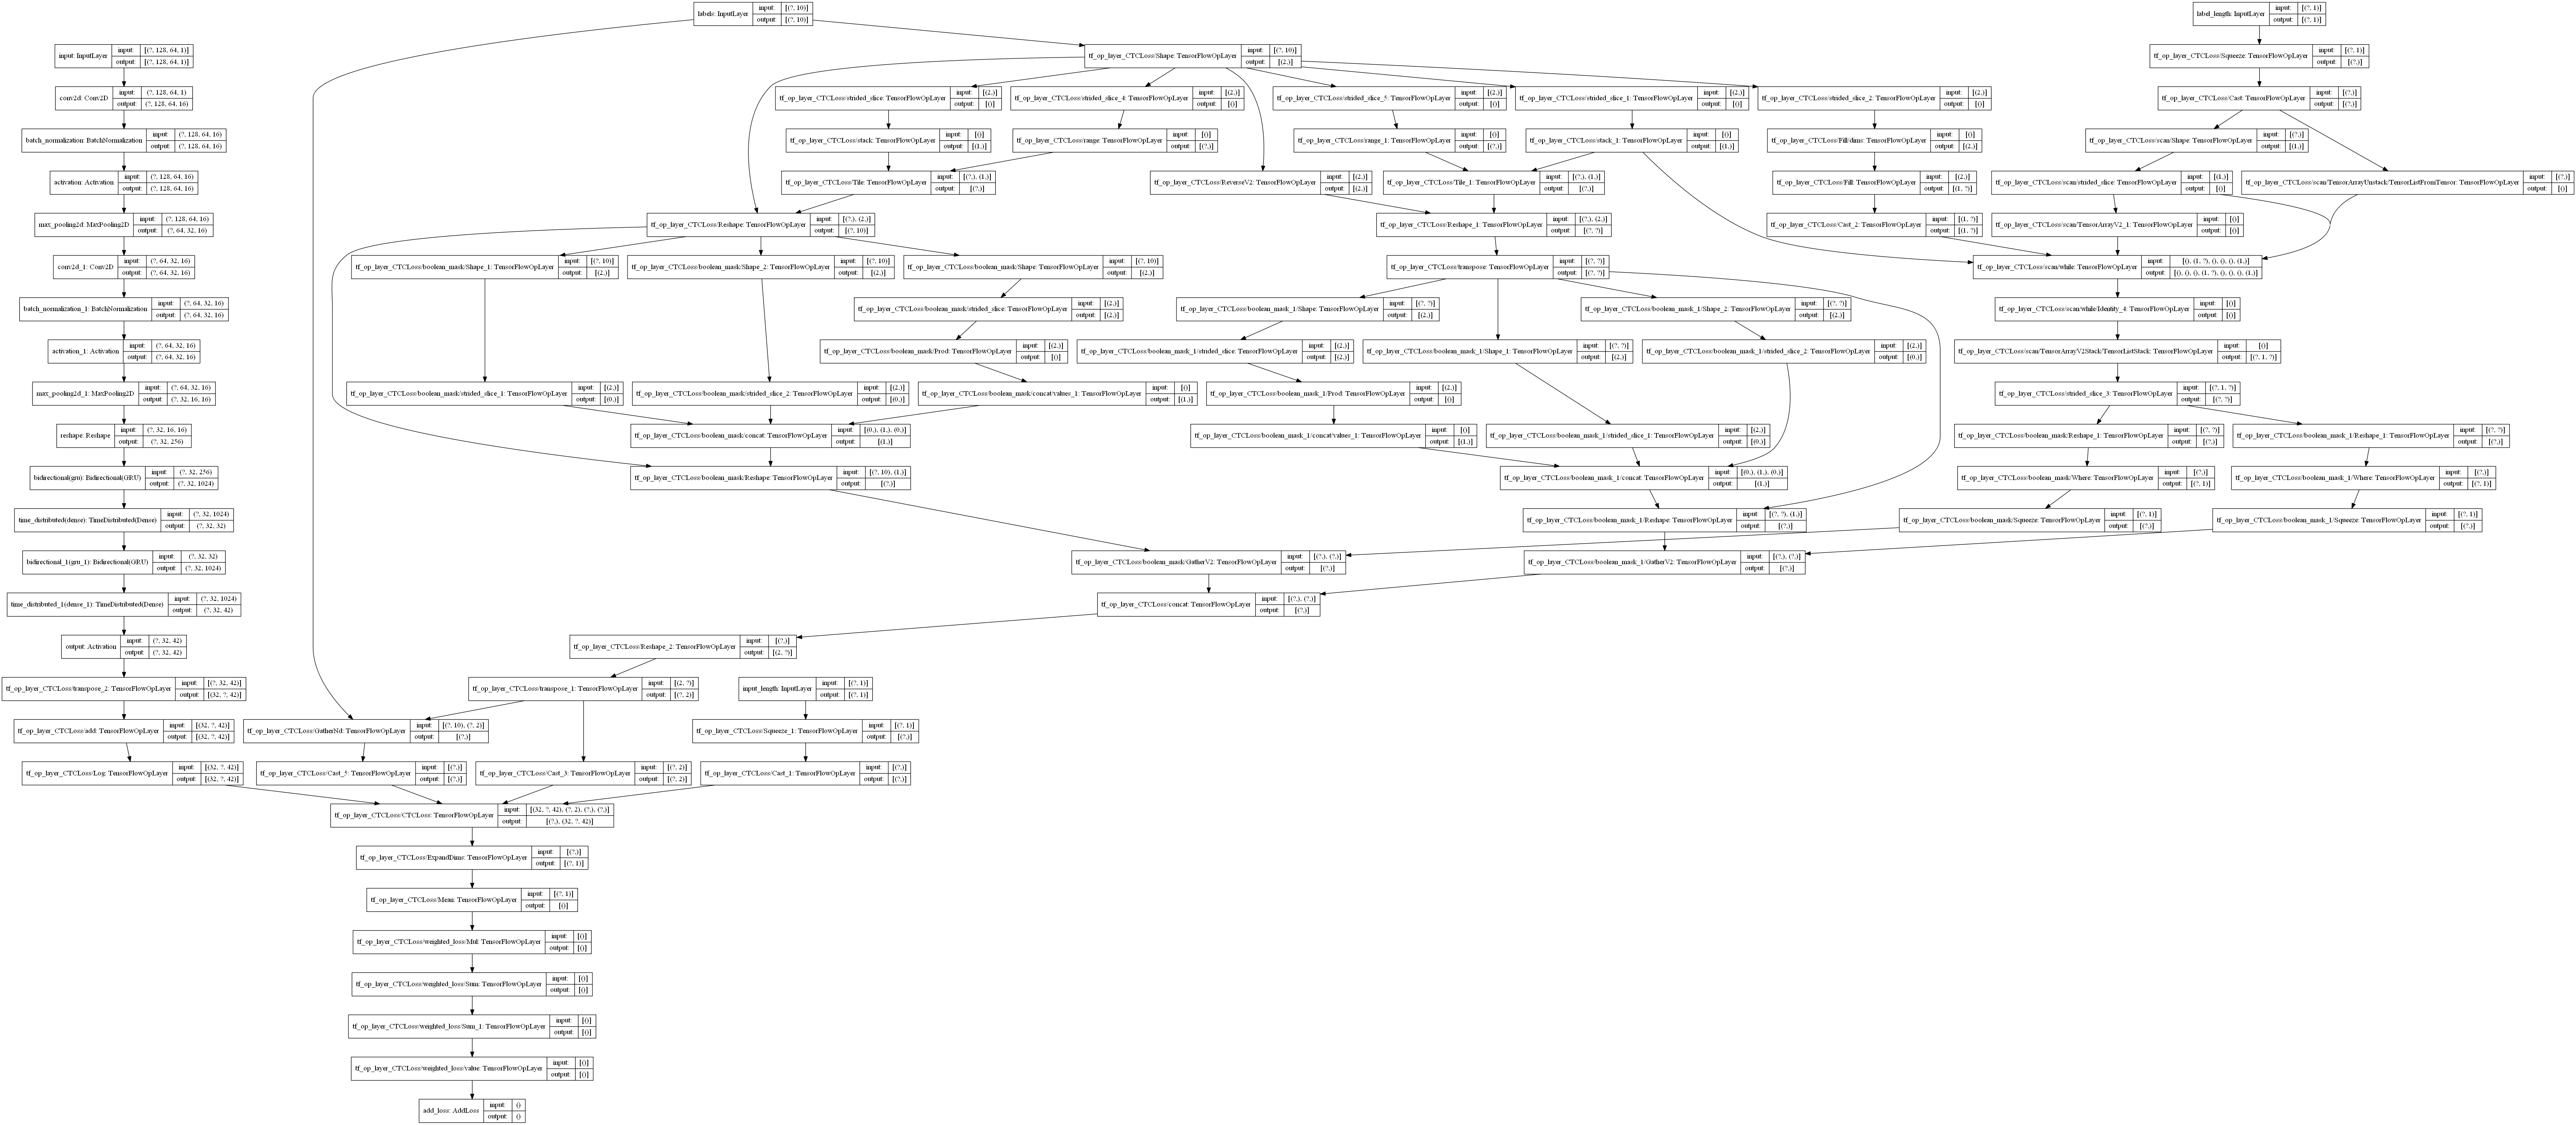

In [7]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

model_architecture_file = os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + '.png'
plot_model(train_model, to_file=model_architecture_file, show_shapes=True)
Image(filename=model_architecture_file)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint

def get_callbacks(weights_path, optimizer):    
    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, mode='min', verbose=1),
        ModelCheckpoint(filepath=MODEL_WEIGHTS_PATH, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1, mode='min'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.01, cooldown=0, min_lr=0),
        TensorBoard(log_dir=os.path.join("logs", optimizer))]
    return callbacks

#### Train the network

In [8]:
history = train_model.fit(
    train_generator.generator(),
    steps_per_epoch=train_generator.numImages // BATCH_SIZE,
    validation_data=val_generator.generator(),
    validation_steps=val_generator.numImages // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=get_callbacks(MODEL_WEIGHTS_PATH, OPTIMIZER), verbose=1)

Epoch 1/1000
163/652 [======>.......................] - ETA: 6:17 - loss: 21.2216
Epoch 00001: val_loss improved from inf to 21.22160, saving model to output\adadelta\clpr-model-weights.h5
652/652 [==============================] - 756s 1s/step - loss: 22.7982 - val_loss: 21.2216
Epoch 2/1000
163/652 [======>.......................] - ETA: 6:07 - loss: 10.8409
Epoch 00002: val_loss improved from 21.22160 to 10.84091, saving model to output\adadelta\clpr-model-weights.h5
652/652 [==============================] - 741s 1s/step - loss: 16.8532 - val_loss: 10.8409
Epoch 3/1000
163/652 [======>.......................] - ETA: 6:13 - loss: 5.0011
Epoch 00003: val_loss improved from 10.84091 to 5.00110, saving model to output\adadelta\clpr-model-weights.h5
652/652 [==============================] - 740s 1s/step - loss: 9.6732 - val_loss: 5.0011
Epoch 4/1000
163/652 [======>.......................] - ETA: 6:14 - loss: 2.0932
Epoch 00004: val_loss improved from 5.00110 to 2.09323, saving model t

#### Create and save prediction model

In [9]:
from tensorflow.keras.models import save_model

predict_model = Model(inputs=inputs, outputs=predictions)
predict_model.load_weights(MODEL_WEIGHTS_PATH)
save_model(predict_model, filepath=MODEL_PATH, save_format="h5")

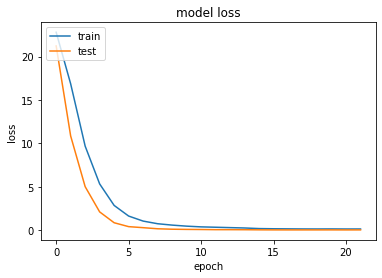

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + "-" + OPTIMIZER + "-train-history.png")
plt.show()

In [11]:
#tf.saved_model.save(predict_model, "out")
predict_model.save('saved_model', save_format='tf')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\IPython\core\interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-1e41a5e563b5>", line 2, in <module>
    predict_model.save('saved_model', save_format='tf')
  File "C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\tensorflow_core\python\keras\engine\network.py", line 1008, in save
    signatures, options)
  File "C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\tensorflow_core\python\keras\saving\save.py", line 115, in save_model
    signatures, options)
  File "C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\tensorflow_core\python\keras\saving\saved_model\save.py", line 78, in save
    save_lib.save(model, filepath, signatures, options)
  File "C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\tensorflow_core\python\saved_model\save.py", line 909, in save
    meta_graph_def, saveable_view

ValueError: Attempted to save a function b'__inference_forward_gru_layer_call_fn_20198' which references a symbolic Tensor Tensor("dropout/mul_1:0", shape=(None, 256), dtype=float32) that is not a simple constant. This is not supported.